# Steinschlagrisiko cwm1

## Aufgabenstellung
Die Kantonsstrasse unterhalb Schiers (GR) ist vom Steinschlag betroffen. Steine lösen sich von zwei unterschiedlichen Stellen an der Felswand ab (Ablösungszone 1 und Ablösungszone 2). Der betroffene Strassenabschnitt ist mit Steinfangnetzen gesichert, die jedoch in die Jahre gekommen sind und die angestrebte Sicherheit nicht mehr gewährleisten können. Die Planung für Ersatznetze hat bereits begonnen, kann aber frühstens in einem Jahr umgesetzt werden.

In den letzten Monaten haben sich mehrere Steinschlagereignisse ereignet. Kommt es im Lauf des nächsten Jahres zu weiteren vergleichbaren Ereignissen, könnten die alten Sicherheitsnetze versagen und die Verkehrsteilnehmer einem grossen Sicherheitsrisiko ausgesetzt sein. Die Bevölkerung ist verunsichert und der Kantonsingenieur muss schnell entscheiden, ob das Risiko für die Verkehrsteilnehmer zu gross ist und die Kantonsstrasse vorübergehend gesperrt werden muss. Der Kantonsingenieur hat sie beauftragt, anhand von vorhanden Daten die Wahrscheinlichkeit eines Todesfalls zu berechnen und eine Empfehlung bezüglich der Schliessung bzw Offenhaltung der Strasse auszusprechen.

Damit die Strasse offen bleiben kann, muss gezeigt werden, dass die jährliche Wahrscheinlichkeit von Todesfällen infolge Steinschlags kleiner als 10-4  ist. Für die Berechnungen soll ein gut strukturierter und dokumentierter Code in Python oder R entwickelt werden.


## Grundlagen
Für die Planung der neuen Sicherheitsnetze, hat ein beauftragter Geologe, über drei Monate Daten zu den Steinschlagereignisse aufgenommen. Dabei wurde Steingeschwindigkeit, Steinmasse und Zeitpunkt und der Zeitpunkt des Ereignis registriert. Diese Daten können von Ihnen zur Modellbildung verwendet werden und stehen unter folgenden Links zur Verfügung:

Ereignis aus Ablösungszone 1: https://www.dropbox.com/s/i58gdv6pzi03rhr/out_1.csv?dl=0

Ereignis aus Ablösungszone 2: https://www.dropbox.com/s/3nk9pv7nzz8f0qb/out_2.csv?dl=0

NB: Die Geschwindigkeit ist durch einen Radar aufgenommen und sehr präzise. Die Masse ist eine Experten-Schätzung des Geologen.
Ein beauftragtes Ingenieurbüro hat geschätzt, dass die Sicherheitsnetze bis zu einer Aufprallenergie von 1000 kJ sicher sind. Falls bereits ein Stein mit über 2000kg in den Sicherheitsnetzen liegt, beträgt die Aufprallenergie, die von den Sicherheitsnetzen aufgenommen werden kann, nur noch 500 kJ. Steine in den Sicherheitsnetze werden vom Unterhaltsteam entfernt (die Reaktionszeit beträgt 24 Stunden).
Das tägliche Verkehrsaufkommen beträgt 1200 Autos. Stau kommt auf der Strecke nicht vor. Die Tempolimite beträgt 60 km/h. 

## 1. Bibliotheken Importieren

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import statistics as st
import scipy.stats as stats
from scipy.stats import norm
import matplotlib.pyplot as plt
from fitter import Fitter, get_common_distributions, get_distributions

## 2. Vorbereitung der Daten
### 2.1 Daten einlesen und reinigen

In [2]:
# Daten laden
df1 = pd.read_csv("out_1.csv")
df2 = pd.read_csv("out_2.csv")

# Spaltennamen von df2 ändern so dass sie die Spaltennamen von df1 entsprechen
df2 = df2.rename(columns={"Date":"Datum","m [kg]":"Masse [kg]","v [m/s]":"Geschwindigkeit [m/s]"})

# Datentabelle auswählen
df1 = df1.loc[:, ["Datum","Uhrzeit","Masse [kg]","Geschwindigkeit [m/s]"]]
df2 = df2.loc[:, ["Datum","Uhrzeit","Masse [kg]","Geschwindigkeit [m/s]"]]

# Spalte Ablösungszone hinzufügen
df1['Ablösungszone'] = 1
df2['Ablösungszone'] = 2

# Zeilen mit NA Werte löschen
df1 = df1.dropna()
df2 = df2.dropna()

Datum und Uhrzeit in einer Spalte zusammenfügen damit daraus einen Datetime Objekt erstellt werden kann.

In [3]:
df1["Datum"] = pd.to_datetime(df1["Datum"] + " " + df1["Uhrzeit"])
df2["Datum"] = pd.to_datetime(df2["Datum"] + " " + df2["Uhrzeit"])

# Uhrzeit Zeile löschen da diese nicht mehr gebraucht wird.
df1 = df1.drop("Uhrzeit", axis=1)
df2 = df2.drop("Uhrzeit", axis=1)

In [4]:
df1

,Datum,Masse [kg],Geschwindigkeit [m/s],Ablösungszone
0,2019-01-01 09:00:00,194.0,8.4,1
1,2019-01-01 21:00:00,224.0,8.8,1
2,2019-01-02 14:00:00,3104.0,9.2,1
3,2019-01-04 15:00:00,228.0,8.0,1
4,2019-01-05 23:00:00,755.0,7.0,1
...,...,...,...,...
63,2019-03-18 16:00:00,167.0,8.9,1
64,2019-03-22 18:00:00,2847.0,7.0,1
65,2019-03-26 00:00:00,44.0,8.9,1
66,2019-03-26 06:00:00,45.0,8.4,1


In [5]:
df2

,Datum,Masse [kg],Geschwindigkeit [m/s],Ablösungszone
0,2019-01-01 09:00:00,38.0,45.4,2
1,2019-01-03 06:00:00,187.0,41.6,2
2,2019-01-04 10:00:00,36.0,44.6,2
3,2019-01-07 14:00:00,6.0,41.2,2
4,2019-01-11 06:00:00,65.0,39.6,2
5,2019-01-11 16:00:00,58.0,33.2,2
6,2019-01-14 11:00:00,365.0,40.2,2
7,2019-01-16 02:00:00,22.0,46.5,2
8,2019-01-18 06:00:00,146.0,36.2,2
9,2019-01-19 17:00:00,29.0,38.3,2


### 2.3 0 - Wert ersetzen
Bei Ablösungszone 2 beträgt die Masse eines Steines 0kg (index 23). Die Masse kann nicht 0 sein, darum setzen wir für diese Masse den Median der Massen aus Zone 2 ein. Der 0 Wert hat keinen Einfluss auf den Median. 

In [6]:
# Median berechnen
list_mass_zone2 = []
m = np.median(df2["Masse [kg]"])
        
# 0-Wert mit Durchschnitt ersetzen
for i in range(len(df2["Masse [kg]"])):
    if df2["Masse [kg]"][i] <= 0:
        df2["Masse [kg]"][i] = m

<ipython-input-6-518c8af640a3>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["Masse [kg]"][i] = m


In [7]:
# Prüfung, dass der neue Wert übernommen wurde
df2["Masse [kg]"][23]

58.0

## 3. Exploratives Datenanalyse

### 3.1 Histogramme

#### Ablösungszone 1

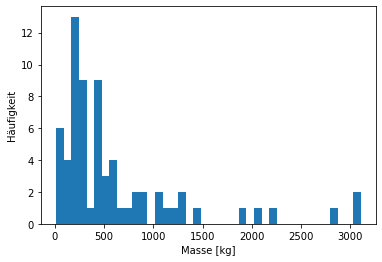

In [8]:
plt.hist(df1["Masse [kg]"], density=False, bins=40)
plt.ylabel('Häufigkeit')
plt.xlabel('Masse [kg]');

#### Ablösungszone 2

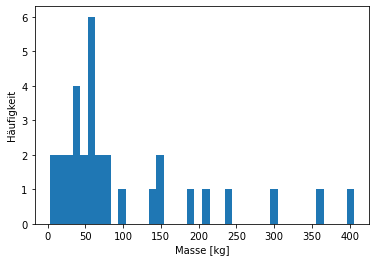

In [9]:
plt.hist(df2["Masse [kg]"], density=False, bins=40)
plt.ylabel('Häufigkeit')
plt.xlabel('Masse [kg]');

### 3.2 Streudiagramme

#### Ablösungszone 1

No handles with labels found to put in legend.


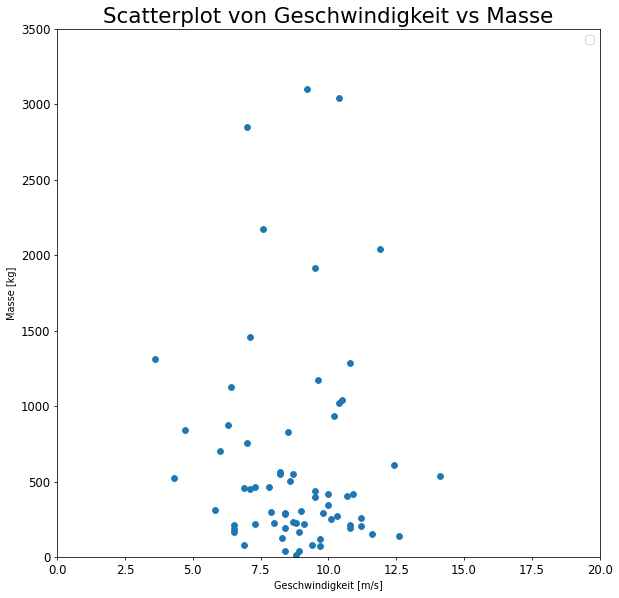

In [10]:
# Draw Plot for Each Category
plt.figure(figsize=(10, 10), dpi= 70, facecolor='w', edgecolor='k')

plt.scatter(df1['Geschwindigkeit [m/s]'], df1['Masse [kg]'])

plt.gca().set(xlim=(0.0, 20), ylim=(0, 3500), xlabel='Geschwindigkeit [m/s]', ylabel='Masse [kg]')

plt.xticks(fontsize=12); plt.yticks(fontsize=12)
plt.title("Scatterplot von Geschwindigkeit vs Masse", fontsize=22)
plt.legend(fontsize=12)    
plt.show()

#### Ablösungszone 2

No handles with labels found to put in legend.


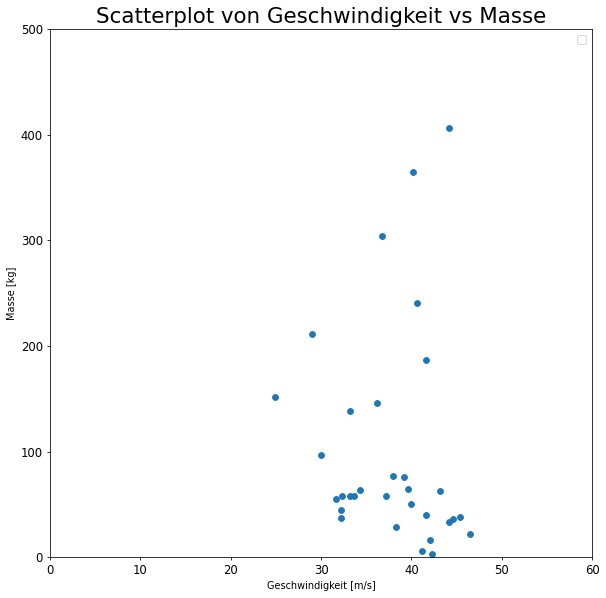

In [11]:
# Draw Plot for Each Category
plt.figure(figsize=(10, 10), dpi= 70, facecolor='w', edgecolor='k')

plt.scatter(df2['Geschwindigkeit [m/s]'], df2['Masse [kg]'])

plt.gca().set(xlim=(0.0, 60), ylim=(0, 500), xlabel='Geschwindigkeit [m/s]', ylabel='Masse [kg]')

plt.xticks(fontsize=12); plt.yticks(fontsize=12)
plt.title("Scatterplot von Geschwindigkeit vs Masse", fontsize=22)
plt.legend(fontsize=12)    
plt.show()

### 3.3 Vergleich Ablösungszone 1 und 2

#### Tabellen zusammenfügen

In [12]:
df3 = pd.concat([df1, df2], ignore_index=True)

#### 3.3.1 Histogramm Masse

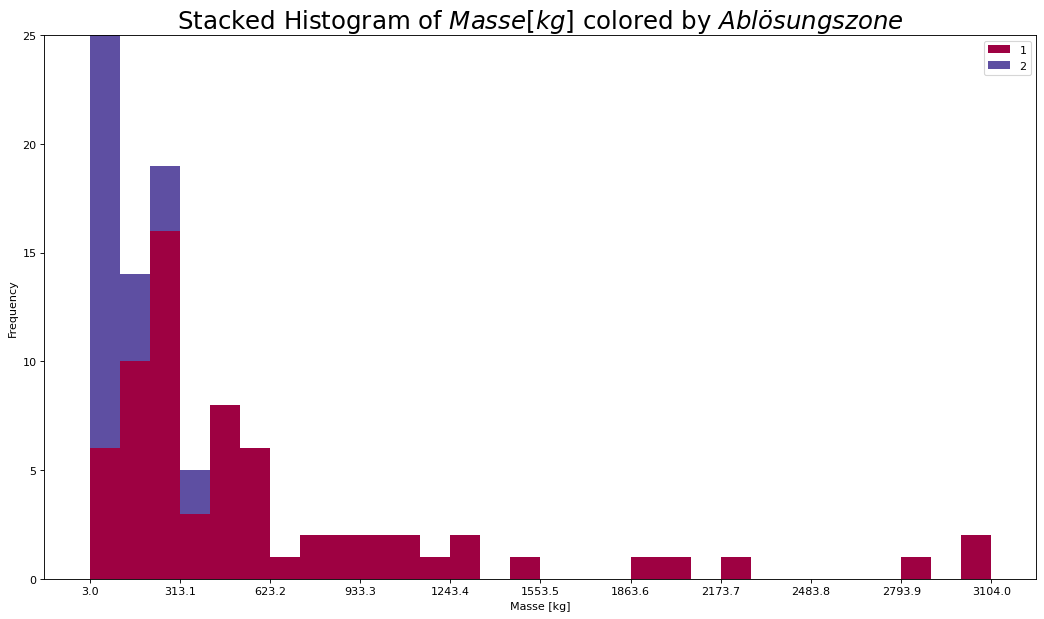

In [13]:
# Prepare data
x_var = 'Masse [kg]'
groupby_var = 'Ablösungszone'
df_agg = df3.loc[:, [x_var, groupby_var]].groupby(groupby_var)
vals = [df3[x_var].values.tolist() for i, df3 in df_agg]

# Draw
plt.figure(figsize=(16,9), dpi= 80)
colors = [plt.cm.Spectral(i/float(len(vals)-1)) for i in range(len(vals))]
n, bins, patches = plt.hist(vals, 30, stacked=True, density=False, color=colors[:len(vals)])

# Decoration
plt.legend({group:col for group, col in zip(np.unique(df3[groupby_var]).tolist(), colors[:len(vals)])})
plt.title(f"Stacked Histogram of ${x_var}$ colored by ${groupby_var}$", fontsize=22)
plt.xlabel(x_var)
plt.ylabel("Frequency")
plt.ylim(0, 25)
plt.xticks(ticks=bins[::3], labels=[round(b,1) for b in bins[::3]])
plt.show()

#### 3.3.2 Histogramm Geschwindigkeit

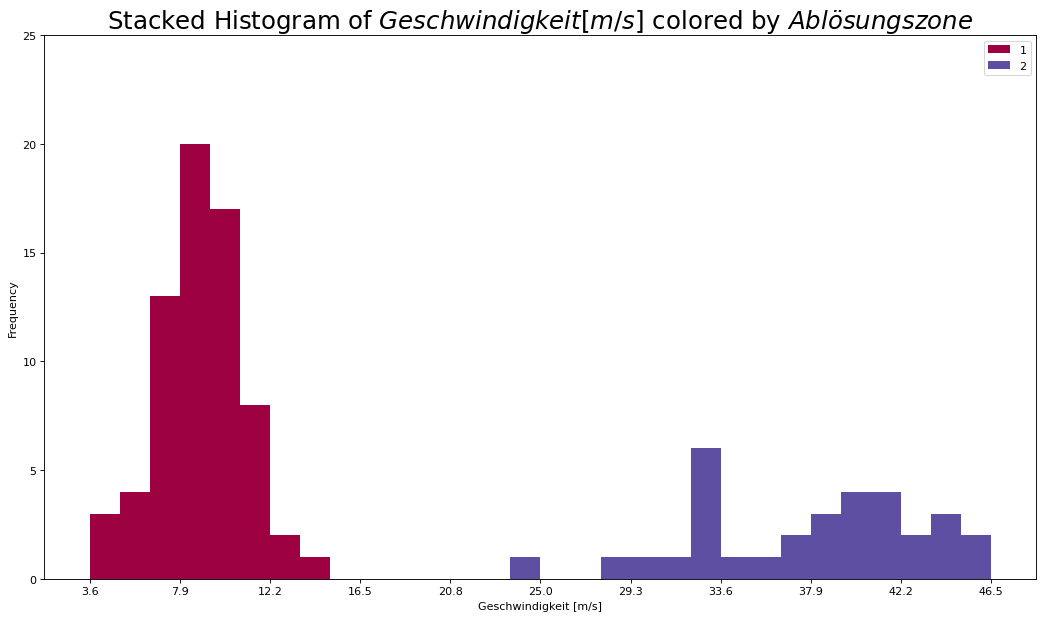

In [14]:
# Prepare data
x_var = 'Geschwindigkeit [m/s]'
groupby_var = 'Ablösungszone'
df_agg = df3.loc[:, [x_var, groupby_var]].groupby(groupby_var)
vals = [df3[x_var].values.tolist() for i, df3 in df_agg]

# Draw
plt.figure(figsize=(16,9), dpi= 80)
colors = [plt.cm.Spectral(i/float(len(vals)-1)) for i in range(len(vals))]
n, bins, patches = plt.hist(vals, 30, stacked=True, density=False, color=colors[:len(vals)])

# Decoration
plt.legend({group:col for group, col in zip(np.unique(df3[groupby_var]).tolist(), colors[:len(vals)])})
plt.title(f"Stacked Histogram of ${x_var}$ colored by ${groupby_var}$", fontsize=22)
plt.xlabel(x_var)
plt.ylabel("Frequency")
plt.ylim(0, 25)
plt.xticks(ticks=bins[::3], labels=[round(b,1) for b in bins[::3]])
plt.show()

#### 3.3.3 Streudiagramm

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


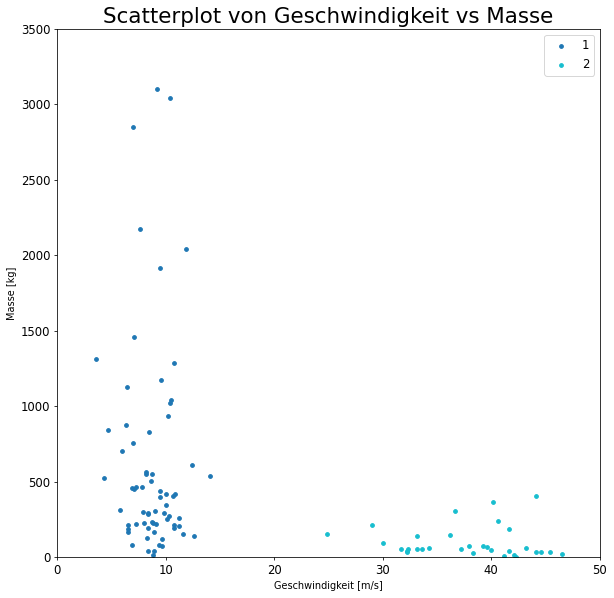

In [15]:
# Create as many colors as there are unique df3['ablösungszone']
categories = np.unique(df3['Ablösungszone'])
colors = [plt.cm.tab10(i/float(len(categories)-1)) for i in range(len(categories))]

# Draw Plot for Each Category
plt.figure(figsize=(10, 10), dpi= 70, facecolor='w', edgecolor='k')

for i, category in enumerate(categories):
    plt.scatter('Geschwindigkeit [m/s]', 'Masse [kg]', 
                data=df3.loc[df3.Ablösungszone == category, :], 
                s=15, c=colors[i], label=str(category))

plt.gca().set(xlim=(0.0, 50), ylim=(0, 3500), xlabel='Geschwindigkeit [m/s]', ylabel='Masse [kg]')

plt.xticks(fontsize=12); plt.yticks(fontsize=12)
plt.title("Scatterplot von Geschwindigkeit vs Masse", fontsize=22)
plt.legend(fontsize=12)    
plt.show()

#### 3.3.4 Bemerkungen

Ablösungszone 1 und 2 sollte man nicht kombinieren, weil die Datensätze stark unterschiedlich sind. Wir nehmen an, dass Ablösungszone 2 steiler ist als Zone 1, aufgrund von der Geschwindigkeit. Bei Ablösungszone 1 befinden sich deutlich massenhaftere Steine als bei Zone 2.

### 3.4 Statistik

In [16]:
df1.describe()

,Masse [kg],Geschwindigkeit [m/s],Ablösungszone
count,68.000000,68.000000,68.0
mean,628.632353,8.788235,1.0
std,695.884703,1.989189,0.0
min,12.000000,3.600000,1.0
25%,214.750000,7.300000,1.0
50%,402.500000,8.800000,1.0
75%,773.000000,10.125000,1.0
max,3104.000000,14.100000,1.0


In [17]:
df2.describe()

,Masse [kg],Geschwindigkeit [m/s],Ablösungszone
count,32.000000,32.000000,32.0
mean,101.062500,37.790625,2.0
std,102.785382,5.395778,0.0
min,3.000000,24.900000,2.0
25%,37.750000,33.200000,2.0
50%,58.000000,38.750000,2.0
75%,140.000000,41.725000,2.0
max,406.000000,46.500000,2.0


## 4. Berechnungen

### 4.1 Kinetische Energie
Hier wird die kinetische Energie von jedem Steinschlag berechnet und zu einer Liste hinzugefügt. Danach wird diese Liste als Spalte in df3 ergänzt.

In [18]:
def calcEnergy(data):
    list_kg = [(x) for x in data["Masse [kg]"]]
    list_ms = [(x) for x in data["Geschwindigkeit [m/s]"]]
    list_kj = [] 

    for i in range(len(list_kg)):
        kj = 0.5 * list_kg[i] * list_ms[i]**2 / 1000
        kj = round(kj,1)
        list_kj.append(kj)

    return list_kj   

In [19]:
kj_zone_1 = calcEnergy(df1)

In [20]:
kj_zone_2 = calcEnergy(df2)

### 4.2 Durchschnitt der Massen berechnen

In [21]:
# Summe / Anzahl Werte
def calcAverage(lst, i):
    return round(sum(lst) / float(len(lst)-i),1)

### 4.3 Zeitbstand von Steinschlägen berechnen
Wir berechnen jetzt die Zeitabstände in Stunden von den Steinschlägen damit wir eine Normalverteilung aufstellen können.

In [22]:
def calcTimeDistance(zone):
    time_distances = []
    for i in range(len(zone)):
        try: 
            distance = int(abs(zone[i] - zone[i+1]).total_seconds() / 3600)
            time_distances.append(distance)
        except Exception:
            pass 
        
    return time_distances

In [23]:
# Create lists with times
dates_zone1 = list(i for i in df1["Datum"])
dates_zone2 = list(i for i in df2["Datum"])
    
time_dist_zone1 = calcTimeDistance(dates_zone1)
time_dist_zone2 = calcTimeDistance(dates_zone2)

avg_time_dist_zone1 = calcAverage(time_dist_zone1, 0)
avg_time_dist_zone2 = calcAverage(time_dist_zone2, 0)

print("Durchschnittlicher Zeitabstand von Steinschlägen in Stunden:")
print("Ablösungszone 1: {}".format(avg_time_dist_zone1))
print("Ablösungszone 2: {}".format(avg_time_dist_zone2))

Durchschnittlicher Zeitabstand von Steinschlägen in Stunden:
Ablösungszone 1: 30.6
Ablösungszone 2: 66.3


## 4. Wahrscheinlichkeitsverteilungen (Zufallsvariablen)

## 5. Netz
Netz Falls bereits ein Stein mit über 2000kg in den Sicherheitsnetzen liegt, beträgt die Aufprallenergie, die von den Sicherheitsnetzen aufgenommen werden kann, nur noch 500 kJ. Steine in den Sicherheitsnetze werden vom Unterhaltsteam entfernt (die Reaktionszeit beträgt 24 Stunden).

- Nach Tag Gruppieren, und summe der Masse im Netz finden. 
- An wie vielen Tagen, hatte das Netz 2000 kg Steine? 
- Was passiert wenn das Netz reist? 
- Wahrscheinlichkeit, dass im Netz 2000 kg sind, gesehen ueber Messzeit. 
- Wahrscheinlickeitm, dass ein Stein mit 500 kj herunterfiel.
- Wann werden die Netze geleert. 

## 6. Verkehr
Das tägliche Verkehrsaufkommen beträgt 1200 Autos. Stau kommt auf der Strecke nicht vor. Die Tempolimite beträgt 60 km/h.
- Wie viele Autos fahren täglich durch?
- Mit welcher Geschwindigkeit?
- Welche Art von Fahrzeugen (PKW, LKW, Töff...)
- Sieht der fahrer den Steinschlag? Kann er bremsen?